# Price stock difference tests

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

# increase plot size
plt.rcParams["figure.figsize"] = (20,8)

font = {'family' : 'DejaVu Sans',
        'size'   : 20}

matplotlib.rc('font', **font)

In [2]:
DATA_PATH = './data'

In [3]:
FILE = DATA_PATH + '/AAPL.txt'

dataset = pd.read_csv(FILE, ' ')

df = dataset.copy()

df.head()

,Date,AAPL.Open,AAPL.High,AAPL.Low,AAPL.Close,AAPL.Volume,AAPL.Adjusted
1,2007-01-03,3.081786,3.092143,2.925000,2.992857,1.238320e+09,2.581791
2,2007-01-04,3.001786,3.069643,2.993572,3.059286,8.472604e+08,2.639096
3,2007-01-05,3.063214,3.078571,3.014286,3.037500,8.347416e+08,2.620302
4,2007-01-08,3.070000,3.090357,3.045714,3.052500,7.971068e+08,2.633242
5,2007-01-09,3.087500,3.320714,3.041071,3.306072,3.349298e+09,2.851985


In [4]:
columns = ['Date', 'AAPL.Close']

df = df.loc[:, columns]

columns = [col.replace('.','_') for col in columns]
df.columns = columns

print(len(df))
df.head()

3525


,Date,AAPL_Close
1,2007-01-03,2.992857
2,2007-01-04,3.059286
3,2007-01-05,3.037500
4,2007-01-08,3.052500
5,2007-01-09,3.306072


In [5]:
df.isna().any()

Date          False
AAPL_Close    False
dtype: bool

### Plot the closing price

In [6]:
import datetime
import matplotlib.dates as mdates



def plot_with_dates(dates, y_values):
    x_values = [datetime.datetime.strptime(d,"%Y-%m-%d").date() for d in df.Date]
    ax = plt.gca()
    ax.set(title='AAPL Stock Closing Price over time', ylabel='Closing price (USD)', xlabel='Time')

    formatter = mdates.DateFormatter("%m-%Y")

    ax.xaxis.set_major_formatter(formatter)

    plt.plot(x_values, y_values)

#plot_with_dates(df.Date, df[columns[1]])

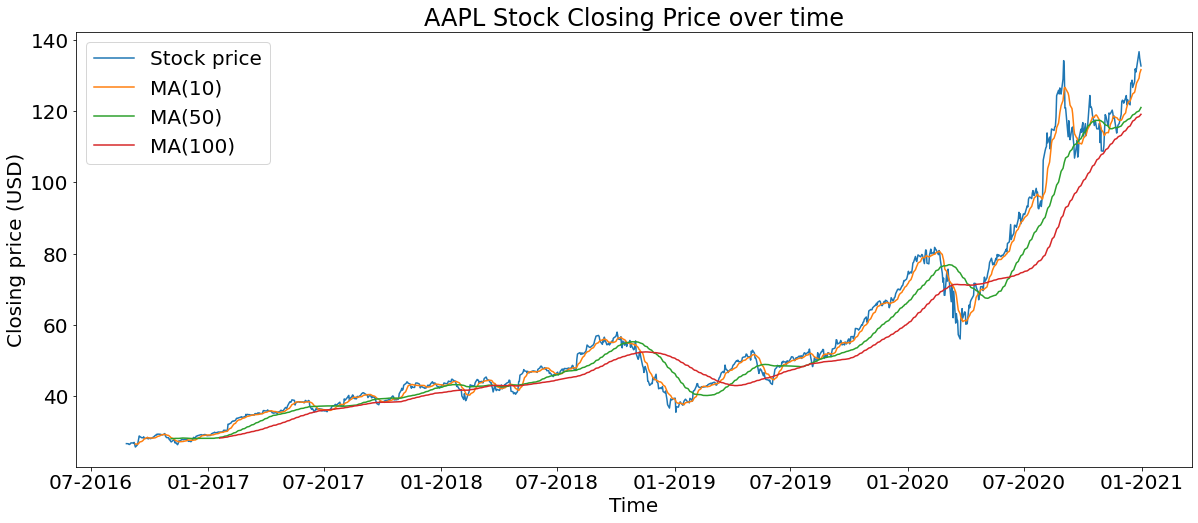

In [7]:
values = df.tail(365*3)['AAPL_Close']

x_values = [datetime.datetime.strptime(d,"%Y-%m-%d").date() for d in df.tail(365*3).Date]
ax = plt.gca()
ax.set(title='AAPL Stock Closing Price over time', ylabel='Closing price (USD)', xlabel='Time')

formatter = mdates.DateFormatter("%m-%Y")

ax.xaxis.set_major_formatter(formatter)

MAs = [10, 50, 100]

plt.plot(x_values, values, label="Stock price")

for val in MAs:
    plt.plot(x_values, values.rolling(val).mean(), label=f"MA({val})")

plt.legend(loc='best')

### Compute the daily stock difference

In [8]:
from itertools import tee

# https://docs.python.org/3/library/itertools.html#itertools-recipes
def pairwise(iterable):
    "s -> (s0,s1), (s1,s2), (s2, s3), ..."
    a, b = tee(iterable)
    next(b, None)
    return zip(a, b)

df.head()

values = df['AAPL_Close']

print(values[:10])

differences = list(map(lambda pair: pair[1]-pair[0], pairwise(values)))
differences.insert(0, 0)

df['Difference'] = differences

df.head()

1     2.992857
2     3.059286
3     3.037500
4     3.052500
5     3.306072
6     3.464286
7     3.421429
8     3.379286
9     3.467857
10    3.391071
Name: AAPL_Close, dtype: float64


,Date,AAPL_Close,Difference
1,2007-01-03,2.992857,0.000000
2,2007-01-04,3.059286,0.066429
3,2007-01-05,3.037500,-0.021786
4,2007-01-08,3.052500,0.015000
5,2007-01-09,3.306072,0.253572


### Outliers removal

In [9]:
from scipy import stats 
import numpy as np 

STD_THRESH = 3

def filter_zscore(serie, thresh=3):
    z = np.abs(stats.zscore(serie)) 
    filtered = (z < 3)
    return serie[filtered]

In [10]:
def label_density_hist(ax, n, bins, x=4, y=0.01, r=0, **kwargs):
    """
    adapted from https://stackoverflow.com/questions/6352740/matplotlib-label-each-bin
    """
    
    total = sum(n)

    # plot the label/text to each bin
    for i in range(0, len(n)):
        x_pos = (bins[i + 1] - bins[i]) / x + bins[i]
        y_pos = n[i] + (n[i] * y)
        
        if n[i] < 10:
            continue
        
        label = f"{(n[i] * 100.0 / total):.1f}%"
        ax.text(x_pos, y_pos, label, kwargs)

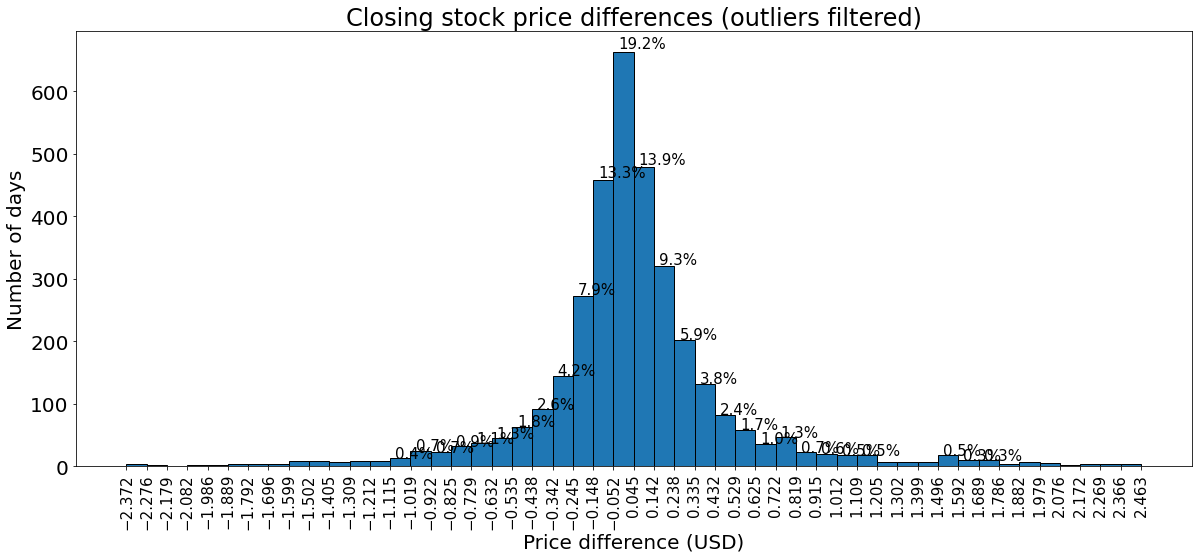

In [11]:
values = filter_zscore(df['Difference'], thresh=STD_THRESH)
ax = plt.gca()

counts, bins, patches = ax.hist(values, 50, histtype='bar', ec='black')
plt.xticks(bins, fontsize=15, rotation=90)
plt.title("Closing stock price differences (outliers filtered)")
plt.xlabel('Price difference (USD)')
plt.ylabel('Number of days')
label_density_hist(ax, counts, bins, fontsize=15)
plt.show()

pas loi normale extrêmes plus importants
garder outliers
travailler pourcentages ~15-18%

[higher] : 1583 (44.9%)
[lower] : 1391 (39.5%)
[stay] : 550 (15.6%)


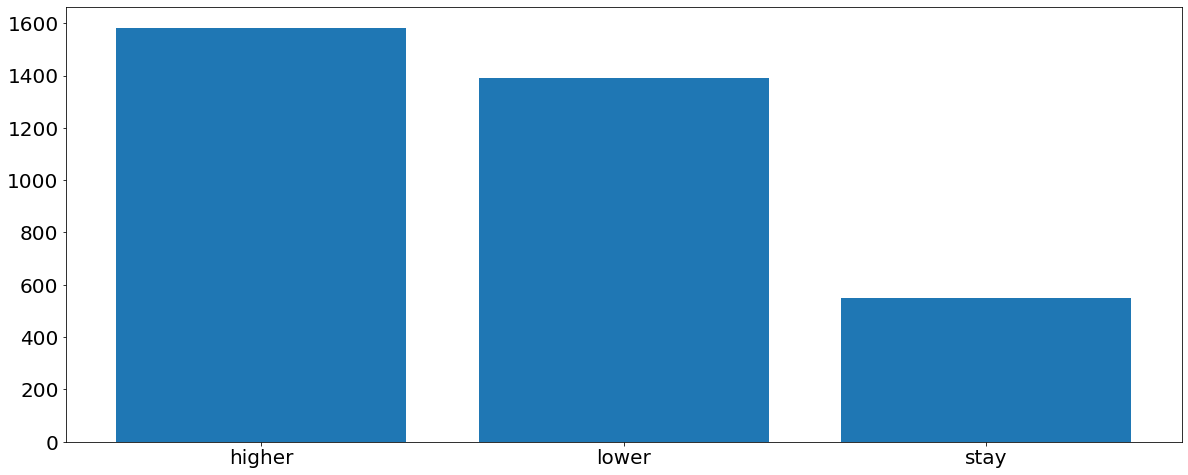

Sum of difference for still price : 0.951


In [12]:
THRESH_DIFF = 0.04

df['Tendency'] = pd.cut(x=df['Difference'], bins=[min(df['Difference']), 0-THRESH_DIFF, 0+THRESH_DIFF, max(df['Difference'])],
                labels=['lower', 'stay', 'higher'])

value_counts = df.Tendency.value_counts().to_dict()


for value, count in value_counts.items():
    print(f"[{value}] : {count} ({count * 100.0 / len(df['Tendency']):.1f}%)")
    
plt.bar(range(len(value_counts.keys())), list(value_counts.values()), align='center')
plt.xticks(range(len(value_counts.keys())), list(value_counts.keys()))

plt.show()

df_stay = df[df.Tendency == 'stay']

print(f"Sum of difference for still price : {df_stay.Difference.sum():.3f}")

In [13]:
def compute_MA(df, n):
    ma = df['AAPL_Close'].rolling(n).mean()
    # replace the NaN for the first n by the current stock value
    """for i in range(0, n):
        ma[i] = df['AAPL_Close'].values[i]"""
    
    df[f"MA({n})"] = ma

compute_MA(df, 10)
print(df)


            Date  AAPL_Close  Difference Tendency      MA(10)
1     2007-01-03    2.992857    0.000000     stay         NaN
2     2007-01-04    3.059286    0.066429   higher         NaN
3     2007-01-05    3.037500   -0.021786     stay         NaN
4     2007-01-08    3.052500    0.015000     stay         NaN
5     2007-01-09    3.306072    0.253572   higher         NaN
...          ...         ...         ...      ...         ...
3521  2020-12-24  131.970001    1.009994   higher  127.828001
3522  2020-12-28  136.690002    4.720001   higher  129.256001
3523  2020-12-29  134.869995   -1.820007    lower  130.565000
3524  2020-12-30  133.720001   -1.149994    lower  131.149001
3525  2020-12-31  132.690002   -1.029999    lower  131.637001

[3525 rows x 5 columns]


In [14]:
def prepare_prices(df):
    prices = df['AAPL_Close']
    prices = prices.shift(periods=-1)
    #prices = prices.replace(np.nan, prices.tail(2).values[0])
    #print(prices.tail(10))
    
    df['Next'] = prices
    
    
    
    
prepare_prices(df)
#df.drop(df.tail(1).index, inplace=True) 

print(df)

            Date  AAPL_Close  Difference Tendency      MA(10)        Next
1     2007-01-03    2.992857    0.000000     stay         NaN    3.059286
2     2007-01-04    3.059286    0.066429   higher         NaN    3.037500
3     2007-01-05    3.037500   -0.021786     stay         NaN    3.052500
4     2007-01-08    3.052500    0.015000     stay         NaN    3.306072
5     2007-01-09    3.306072    0.253572   higher         NaN    3.464286
...          ...         ...         ...      ...         ...         ...
3521  2020-12-24  131.970001    1.009994   higher  127.828001  136.690002
3522  2020-12-28  136.690002    4.720001   higher  129.256001  134.869995
3523  2020-12-29  134.869995   -1.820007    lower  130.565000  133.720001
3524  2020-12-30  133.720001   -1.149994    lower  131.149001  132.690002
3525  2020-12-31  132.690002   -1.029999    lower  131.637001         NaN

[3525 rows x 6 columns]


In [15]:
df_date = df['Date']

In [16]:
df = df.drop(columns=['Tendency', 'Date'])
df = df.dropna()
df.head()

,AAPL_Close,Difference,MA(10),Next
10,3.391071,-0.076786,3.257214,3.181072
11,3.181072,-0.209999,3.276036,3.160714
12,3.160714,-0.020358,3.286179,3.099643
13,3.099643,-0.061071,3.292393,3.060714
14,3.060714,-0.038929,3.293214,3.096429


In [17]:
X = df.loc[:, df.columns != 'Next']
Y = df['Next']

In [18]:
from sklearn.model_selection import train_test_split
TRAIN_RATIO = 0.8

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=TRAIN_RATIO, random_state=42)

In [19]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X_train, Y_train)

In [26]:
from sklearn.metrics import mean_squared_error

y_pred = reg.predict(X_test)
mean_squared_error(Y_test, y_pred)

[ 29.41817978   3.54038597   6.38002983   6.39266527  28.88177279
   5.00781261  11.12851111  21.83497951   4.543682    28.57590416
   5.04076117   4.61931442  71.06068517   4.50757483  40.64430333
  22.16554334  27.20431486  55.60624871   9.18609214   5.63301614
   8.88911697  15.90310474  23.93658375  27.22943352   7.23204457
 115.16682404   3.1755744   31.83434233  11.4859001   46.74207356
  13.41483589  26.48735195   5.45867187   8.65514118  26.08307801
  52.27744012  18.98816217   6.08008197  12.51778144  18.56682108
   4.80584189  24.43617962   3.21741689  69.05988601  33.14233844
  18.51934165  42.87973468  29.77435848  32.22087562   3.15832333
   3.38459128   6.64234508   3.20243805   3.05869995  39.20360685
  65.13631508  10.28978862 111.99687371  20.59067462   3.53253835
  67.04697383   3.29940179 114.50359622   6.18450984  12.83491153
  16.55857339  28.83906238  41.89019832   7.50091533   5.93544485
  35.39263768  28.29477148  16.48614289  24.37971065   6.03356563
  32.16203

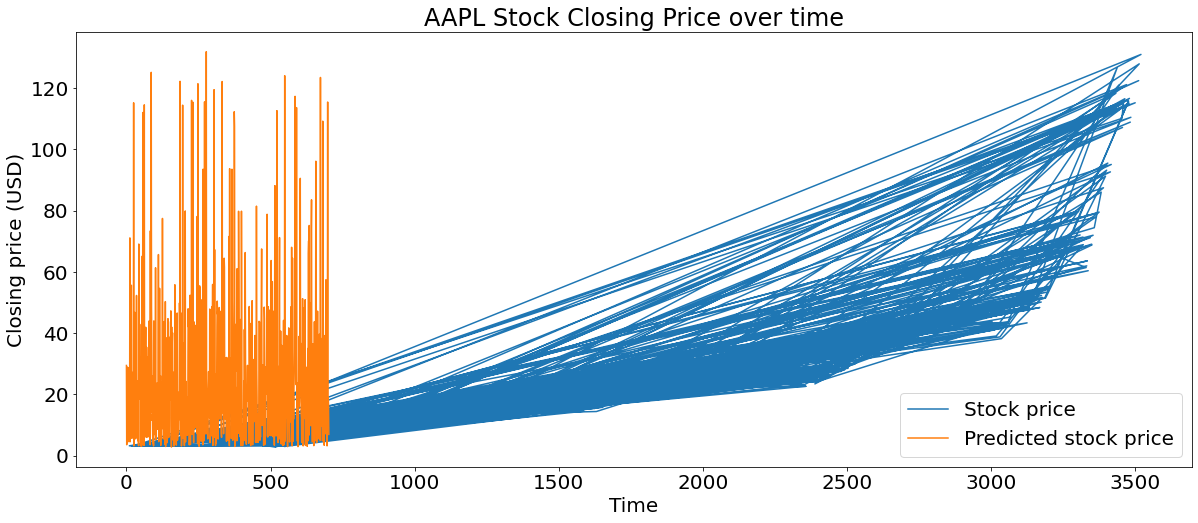

In [24]:
ax = plt.gca()
ax.set(title='AAPL Stock Closing Price over time', ylabel='Closing price (USD)', xlabel='Time')

plt.plot(Y_test, label="Stock price")
plt.plot(y_pred, label="Predicted stock price")

plt.legend(loc='best')